# IT Ticket Classifier — DHAUZ Challenge

Notebook executável: carrega o dataset, amostra 200 tickets, monta o RAG (embeddings + FAISS), executa o fluxo LangGraph em exemplos e na amostra, calcula métricas.
Arquitetura baseada em pesquisa com experimentação em "labs/architecture-comparison.ipynb"

![Arquitetura proposta](architecture.drawio.png)

### Resultados do labs (architecture-comparison)

Gráfico de threshold KNN (cruzamento coverage × F1 macro) e tabela comparativa de modelos no conjunto de teste (hold-out excl. sample_200).

![KNN: métricas vs confidence threshold](charts/threshold.png)

Resultado mostra que threshold para maior coverage e maio f1 macro é 0.45
Cruzamento (coverage ≈ F1 macro): threshold=0.45 → coverage=90.35%, F1 macro=0.8697, accuracy=0.8680

Melhor equilíbrio (max coverage×F1): threshold=0.35 → coverage=95.31%, F1 macro=0.8450, accuracy=0.8424

**Tabela comparativa (test set):**

| model    | accuracy | f1_macro | f1_weighted |
|----------|----------|----------|-------------|
| RNN      | 0.772571 | 0.763023 | 0.773050    |
| LSTM     | 0.800138 | 0.794236 | 0.801268    |
| BiLSTM   | 0.831840 | 0.835082 | 0.832611    |
| BiGRU    | 0.833218 | 0.838499 | 0.833300    |
| CNN+BiGRU| 0.837354 | 0.842469 | 0.837848    |
| KNN      | 0.833218 | 0.832331 | 0.832036    |

### usaremos KNN pelo motivo de ser mais explicável e permitir construir uma base de conhecimento muito granular, veja mais em **[labs/architecture-comparison.ipynb](labs/architecture-comparison.ipynb)**

In [1]:
import os
import sys
import numpy as np
from pathlib import Path

ROOT = Path(".").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from dotenv import load_dotenv
load_dotenv(ROOT / ".env")

import config
np.random.seed(config.SEED)

## 0. Baixar dataset do Kaggle (só se ainda não tiver o CSV em data/raw)

In [2]:
from src.prep import download_from_kaggle

path = download_from_kaggle()
print(f"Dataset em: {path}")

Dataset em: /Users/moises/Documents/ticket-classifier/data/raw/all_tickets_processed_improved_v3.csv


## 1. Dataset completo → vector store; sample_200 → test set

In [3]:
import pandas as pd
from src.prep import document_text, load_dataset, get_text_and_label_columns, stratified_sample
from src.rag import VectorStore

df_full = load_dataset()
text_cols, label_col = get_text_and_label_columns(df_full)
classes = sorted(set(df_full[label_col].astype(str)))

n_sample = min(config.SAMPLE_SIZE, len(df_full))
df_sample = stratified_sample(df_full, label_col, n=n_sample)
df_sample.to_csv(config.DATA_PROCESSED / "sample_200.csv", index=False)
ids_test = set(df_sample["id"])
df_train = df_full[~df_full["id"].isin(ids_test)]

texts_train = [document_text(row, text_cols) for _, row in df_train.iterrows()]
labels_train = df_train[label_col].astype(str).tolist()
ids_train = df_train["id"].tolist()

artifact_path = config.ARTIFACTS_DIR
if (artifact_path / "index.faiss").exists():
    store = VectorStore.load(artifact_path)
    print("Vector store carregado de:", artifact_path)
else:
    vc = VectorStore()
    store = vc.build(texts_train, labels_train, ids=ids_train)
    store.save(artifact_path)
    print("Vector store construído (apenas train) e salvo em:", artifact_path)

texts = [document_text(row, text_cols) for _, row in df_sample.iterrows()]

print("Classes:", classes)
print("Vector store (train): %d documentos" % len(df_train))
print("Test set (sample_200): %d tickets" % len(df_sample))

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Vector store carregado de: /Users/moises/Documents/ticket-classifier/outputs/artifacts
Classes: ['Access', 'Administrative rights', 'HR Support', 'Hardware', 'Internal Project', 'Miscellaneous', 'Purchase', 'Storage']
Vector store (train): 47637 documentos
Test set (sample_200): 200 tickets


## 1.1 Estatísticas: dataset completo e sample_200

Dataset completo: 47837 tickets | 8 classes
Sample 200: 200 tickets (estratificado)



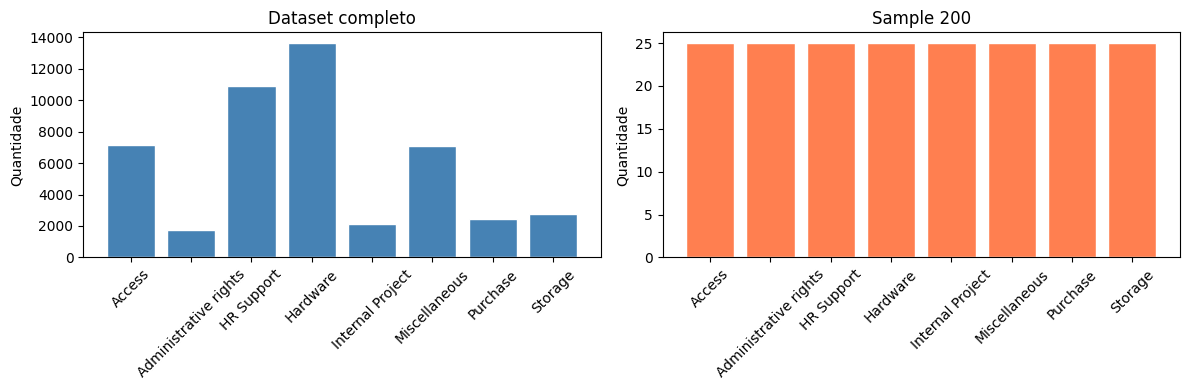

In [4]:
import matplotlib.pyplot as plt

print("Dataset completo:", len(df_full), "tickets |", len(classes), "classes")
print("Sample 200:", len(df_sample), "tickets (estratificado)")
print()

count_full = df_full[label_col].astype(str).value_counts().sort_index()
count_sample = df_sample[label_col].astype(str).value_counts().reindex(count_full.index, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(count_full.index, count_full.values, color="steelblue", edgecolor="white")
axes[0].set_title("Dataset completo")
axes[0].set_ylabel("Quantidade")
axes[0].tick_params(axis="x", rotation=45)

axes[1].bar(count_sample.index, count_sample.values, color="coral", edgecolor="white")
axes[1].set_title("Sample 200")
axes[1].set_ylabel("Quantidade")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

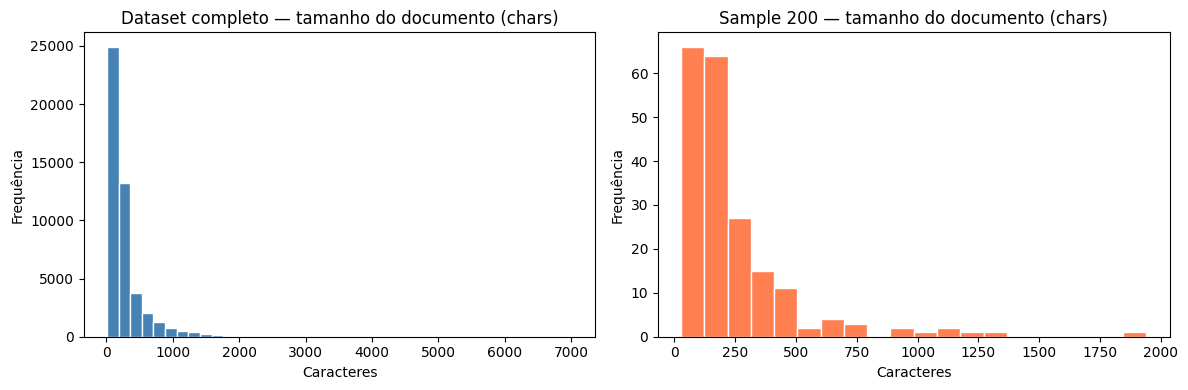

Dataset completo: min=7, max=7015, mediana=175 chars
Sample 200: min=29, max=1940, mediana=170 chars


In [5]:
doc_len_full = df_full[text_cols[0]].fillna("").astype(str).str.len()
doc_len_sample = df_sample[text_cols[0]].fillna("").astype(str).str.len()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(doc_len_full, bins=40, color="steelblue", edgecolor="white")
axes[0].set_title("Dataset completo — tamanho do documento (chars)")
axes[0].set_xlabel("Caracteres")
axes[0].set_ylabel("Frequência")

axes[1].hist(doc_len_sample, bins=20, color="coral", edgecolor="white")
axes[1].set_title("Sample 200 — tamanho do documento (chars)")
axes[1].set_xlabel("Caracteres")
axes[1].set_ylabel("Frequência")

plt.tight_layout()
plt.show()
print("Dataset completo: min=%d, max=%d, mediana=%.0f chars" % (doc_len_full.min(), doc_len_full.max(), doc_len_full.median()))
print("Sample 200: min=%d, max=%d, mediana=%.0f chars" % (doc_len_sample.min(), doc_len_sample.max(), doc_len_sample.median()))

## 2. Inferência em exemplos


In [6]:
# store, classes e texts já carregados na célula 1.
import logging
from tqdm.auto import tqdm
from src.graph import build_pipeline, run_pipeline

logging.getLogger("ticket_classifier.llm_usage").setLevel(logging.WARNING)

compiled, _, _ = build_pipeline(store)

for i in tqdm(range(min(3, len(texts))), desc="Exemplos"):
    out = run_pipeline(compiled, texts[i], classes)
    print(f"--- Ticket {i+1} ---")
    print("Texto (trecho):", texts[i][:150], "...")
    print("Saída:", out)
    print()

Exemplos:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
{"step": "knn_classify", "event": "classification", "classe": "Hardware", "confidence": 1.0}
llama_context: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4          

--- Ticket 1 ---
Texto (trecho): monitor request vulcan friday october pm hello please log each user monitor allocation user vulcan thank weekend engineer friday october vulcan parte  ...
Saída: {'classe': 'Hardware', 'justificativa': "Os termos 'monitor', 'vulcan', 'request', 'allocation' e 'log' correlacionam com a classe 'Hardware' pois mencionam a gestão de recursos de hardware. Além disso, os vizinhos KNN também mencionam 'monitor' e 'allocation', o que reforça a correlação com a classe 'Hardware'.", 'classification_source': 'knn', 'confidence': 1.0, 'inference_time_sec': 28.879202208001516, 'classification_tokens': None, 'justification_tokens': 486}



{"step": "knn_classify", "event": "classification", "classe": "Hardware", "confidence": 0.5714}
{"step": "agent_justify", "event": "justification", "input_tokens": 339, "output_tokens": 99, "total_tokens": 438}
{"step": "inference", "event": "inference", "classification_source": "knn", "classe": "Hardware", "inference_time_sec": 16.7171, "justification_tokens": 438}


--- Ticket 2 ---
Texto (trecho): stopped when docker start was executed sent wednesday february hi we having same problem we had few days ago server was stopped when executed docker s ...
Saída: {'classe': 'Hardware', 'justificativa': "O termo 'server stopped' é comum em todos os vizinhos e no próprio ticket, indicando que a classe atribuída 'Hardware' está relacionada a problemas de acesso ao servidor. Além disso, a menção a 'docker' e 'machine' nos vizinhos #0 e #3, e no próprio ticket, sugere que a classe está relacionada a problemas de execução de containers Docker.", 'classification_source': 'knn', 'confidence': 0.5714285714285714, 'inference_time_sec': 16.71705991699855, 'classification_tokens': None, 'justification_tokens': 438}



{"step": "knn_classify", "event": "classification", "classe": "Hardware", "confidence": 1.0}
{"step": "agent_justify", "event": "justification", "input_tokens": 402, "output_tokens": 121, "total_tokens": 523}
{"step": "inference", "event": "inference", "classification_source": "knn", "classe": "Hardware", "inference_time_sec": 20.0555, "justification_tokens": 523}


--- Ticket 3 ---
Texto (trecho): issue re access through for hello still work attached log error received during installation restarted machine disconnected tethered phone can connect ...
Saída: {'classe': 'Hardware', 'justificativa': "Os termos 're access through for hello still work attached log error received during installation restarted machine disconnected tethered phone can connect' correlacionam com a classe 'Hardware' pois mencionam problemas de conexão e instalação, que são comuns em problemas de hardware. Além disso, os vizinhos KNN (#0, #1, #2, #3, #4, #5 e #6) também mencionam problemas de conexão e instalação, o que reforça a classificação de 'Hardware'.", 'classification_source': 'knn', 'confidence': 1.0, 'inference_time_sec': 20.055529500001285, 'classification_tokens': None, 'justification_tokens': 523}



## 3. Rodar na amostra de 200 e salvar resultados

In [16]:
import logging
import time
from src.logging_utils import log_result
from tqdm.auto import tqdm
os.environ["LLM_BACKEND"] = "llama_cpp"
from src.llm_local.backend import reset_llm_backend
reset_llm_backend()
logging.getLogger("ticket_classifier.llm_usage").setLevel(logging.WARNING)

results_path = config.OUTPUTS / "results_sample.jsonl"
if results_path.exists():
    results_path.unlink()

max_tickets = None
it = list(df_sample.iterrows())
if max_tickets is not None:
    it = it[:max_tickets]

predictions = []
t0 = time.perf_counter()
for pos, (_, row) in enumerate(tqdm(it, desc="Pipeline")):
    text = document_text(row, text_cols)
    out = run_pipeline(compiled, text, classes, instance_id=row["id"])
    pred = out["classe"]
    predictions.append(pred)
    log_result({
        "id": row["id"],
        "ticket_index": pos,
        "text": text,
        "true": row[label_col],
        "pred": pred,
        "justificativa": out["justificativa"],
        "classification_source": out.get("classification_source"),
        "confidence": out.get("confidence"),
        "inference_time_sec": out.get("inference_time_sec"),
        "classification_tokens": out.get("classification_tokens"),
        "justification_tokens": out.get("justification_tokens"),
    })
elapsed = time.perf_counter() - t0
n = len(predictions)
print(f"Salvos {n} resultados em {results_path}")
print(f"Tempo total: {elapsed:.1f}s | Média por ticket: {elapsed/n:.1f}s (gargalo: 1 chamada LLM por ticket)")

Pipeline:   0%|          | 0/200 [00:00<?, ?it/s]

llama_context: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64

Salvos 200 resultados em /Users/moises/Documents/ticket-classifier/outputs/results_sample.jsonl
Tempo total: 7065.3s | Média por ticket: 35.3s (gargalo: 1 chamada LLM por ticket)


## 3b. Rodar na amostra de 200 com threshold 0

Mesma amostra, mas com **confidence threshold = 0**: todo ticket passa para KNN + justificativa LLM (nenhum usa só LLM).

In [ ]:
results_path_th0 = config.OUTPUTS / "results_sample_threshold0.jsonl"
if results_path_th0.exists():
    results_path_th0.unlink()

predictions_th0 = []
t0 = time.perf_counter()
for pos, (_, row) in enumerate(tqdm(list(df_sample.iterrows()), desc="Pipeline (threshold=0)")):
    text = document_text(row, text_cols)
    out = run_pipeline(compiled, text, classes, instance_id=row["id"], confidence_threshold=0.0)
    predictions_th0.append(out["classe"])
    log_result(
        {
            "id": row["id"],
            "ticket_index": pos,
            "true": row[label_col],
            "pred": out["classe"],
            "justificativa": out["justificativa"],
            "classification_source": out.get("classification_source"),
            "confidence": out.get("confidence"),
            "inference_time_sec": out.get("inference_time_sec"),
        },
        path=results_path_th0,
    )
elapsed = time.perf_counter() - t0
print(f"Salvos {len(predictions_th0)} resultados em {results_path_th0}")
print(f"Tempo total: {elapsed:.1f}s | Média por ticket: {elapsed/len(predictions_th0):.1f}s")

Pipeline (threshold=0):   0%|          | 0/200 [00:00<?, ?it/s]

Salvos 200 resultados em /Users/moises/Documents/ticket-classifier/outputs/results_sample_threshold0.jsonl
Tempo total: 4426.6s | Média por ticket: 22.1s


## EXTRA: Rodar com Groq

Define `LLM_BACKEND=groq`, reseta o backend e roda a pipeline nos mesmos 200 tickets (vector store já carregado). A seção 4 calcula as métricas incluindo esta run.

In [10]:
import os
import time
from tqdm.auto import tqdm
from src.logging_utils import log_result
os.environ["LLM_BACKEND"] = "groq"
os.environ["GROQ_MODEL"] = "llama-3.1-8b-instant"
from src.llm_local.backend import reset_llm_backend
reset_llm_backend()

logging.getLogger("ticket_classifier.llm_usage").setLevel(logging.WARNING)

results_path_groq = config.OUTPUTS / "results_sample_groq.jsonl"
if results_path_groq.exists():
    results_path_groq.unlink()

predictions_groq = []
t0 = time.perf_counter()
for pos, (_, row) in enumerate(tqdm(list(df_sample.iterrows()), desc="Pipeline (Groq)")):
    text = document_text(row, text_cols)
    out = run_pipeline(compiled, text, classes, instance_id=row["id"])
    predictions_groq.append(out["classe"])
    log_result(
        {
            "id": row["id"],
            "ticket_index": pos,
            "true": row[label_col],
            "pred": out["classe"],
            "justificativa": out["justificativa"],
            "classification_source": out.get("classification_source"),
            "confidence": out.get("confidence"),
            "inference_time_sec": out.get("inference_time_sec"),
        },
        path=results_path_groq,
    )
elapsed = time.perf_counter() - t0
print(f"Salvos {len(predictions_groq)} resultados em {results_path_groq}")
print(f"Tempo total: {elapsed:.1f}s | Média por ticket: {elapsed/len(predictions_groq):.1f}s")

Pipeline (Groq):   0%|          | 0/200 [00:00<?, ?it/s]

Salvos 200 resultados em /Users/moises/Documents/ticket-classifier/outputs/results_sample_groq.jsonl
Tempo total: 891.9s | Média por ticket: 4.5s


## 4. Métricas e relatório

In [17]:
import json
from pathlib import Path

def load_predictions_from_jsonl(path: Path) -> list[str]:
    preds = []
    with open(path) as f:
        for line in f:
            line = line.strip()
            if line:
                preds.append(json.loads(line)["pred"])
    return preds

out = config.OUTPUTS
predictions = load_predictions_from_jsonl(out / "results_sample.jsonl")
predictions_th0 = load_predictions_from_jsonl(out / "results_sample_threshold0.jsonl")
predictions_groq = load_predictions_from_jsonl(out / "results_sample_groq.jsonl") if (out / "results_sample_groq.jsonl").exists() else None

In [18]:
from src.metrics import compute_metrics, save_metrics_report

y_true = df_sample[label_col].astype(str).tolist()

metrics_knn = compute_metrics(y_true, predictions, labels=classes)
metrics_th0 = compute_metrics(y_true, predictions_th0, labels=classes)
save_metrics_report(metrics_knn)

tabela_rows = [
    {"run": "KNN + Fallback LLM (threshold=0.45)", "accuracy": metrics_knn["accuracy"], "f1_macro": metrics_knn["f1_macro"], "f1_weighted": metrics_knn["f1_weighted"]},
    {"run": "100% KNN (threshold=0)", "accuracy": metrics_th0["accuracy"], "f1_macro": metrics_th0["f1_macro"], "f1_weighted": metrics_th0["f1_weighted"]},
]
try:
    metrics_groq = compute_metrics(y_true, predictions_groq, labels=classes)
    tabela_rows.append({"run": "Groq (threshold=0.45)", "accuracy": metrics_groq["accuracy"], "f1_macro": metrics_groq["f1_macro"], "f1_weighted": metrics_groq["f1_weighted"]})
    report_groq = metrics_groq["classification_report"]
except NameError:
    report_groq = {}
tabela = pd.DataFrame(tabela_rows)
display(tabela)

report_knn = metrics_knn["classification_report"]
report_th0 = metrics_th0["classification_report"]
por_classe = []
for c in classes:
    if c not in report_knn or not isinstance(report_knn[c], dict):
        continue
    row = {
        "classe": c,
        "precision (KNN+th)": report_knn[c]["precision"],
        "recall (KNN+th)": report_knn[c]["recall"],
        "f1 (KNN+th)": report_knn[c]["f1-score"],
        "precision (100% KNN)": report_th0.get(c, {}).get("precision", 0),
        "recall (100% KNN)": report_th0.get(c, {}).get("recall", 0),
        "f1 (100% KNN)": report_th0.get(c, {}).get("f1-score", 0),
    }
    if report_groq:
        row["precision (Groq)"] = report_groq.get(c, {}).get("precision", 0)
        row["recall (Groq)"] = report_groq.get(c, {}).get("recall", 0)
        row["f1 (Groq)"] = report_groq.get(c, {}).get("f1-score", 0)
    por_classe.append(row)
display(pd.DataFrame(por_classe))

,run,accuracy,f1_macro,f1_weighted
0,KNN + Fallback LLM (threshold=0.45),0.820,0.820206,0.820206
1,100% KNN (threshold=0),0.845,0.847253,0.847253
2,Groq (threshold=0.45),0.810,0.809511,0.809511


,classe,precision (KNN+th),recall (KNN+th),f1 (KNN+th),precision (100% KNN),recall (100% KNN),f1 (100% KNN),precision (Groq),recall (Groq),f1 (Groq)
0,Access,0.821429,0.92,0.867925,0.821429,0.92,0.867925,0.851852,0.92,0.884615
1,Administrative rights,0.928571,0.52,0.666667,0.944444,0.68,0.790698,0.866667,0.52,0.650000
2,HR Support,0.777778,0.84,0.807692,0.636364,0.84,0.724138,0.724138,0.84,0.777778
3,Hardware,0.760000,0.76,0.760000,0.750000,0.84,0.792453,0.760000,0.76,0.760000
4,Internal Project,0.950000,0.76,0.844444,0.950000,0.76,0.844444,0.950000,0.76,0.844444
5,Miscellaneous,0.589744,0.92,0.718750,0.840000,0.84,0.840000,0.600000,0.84,0.700000
6,Purchase,0.960000,0.96,0.960000,1.000000,0.96,0.979592,0.888889,0.96,0.923077
7,Storage,1.000000,0.88,0.936170,0.958333,0.92,0.938776,1.000000,0.88,0.936170


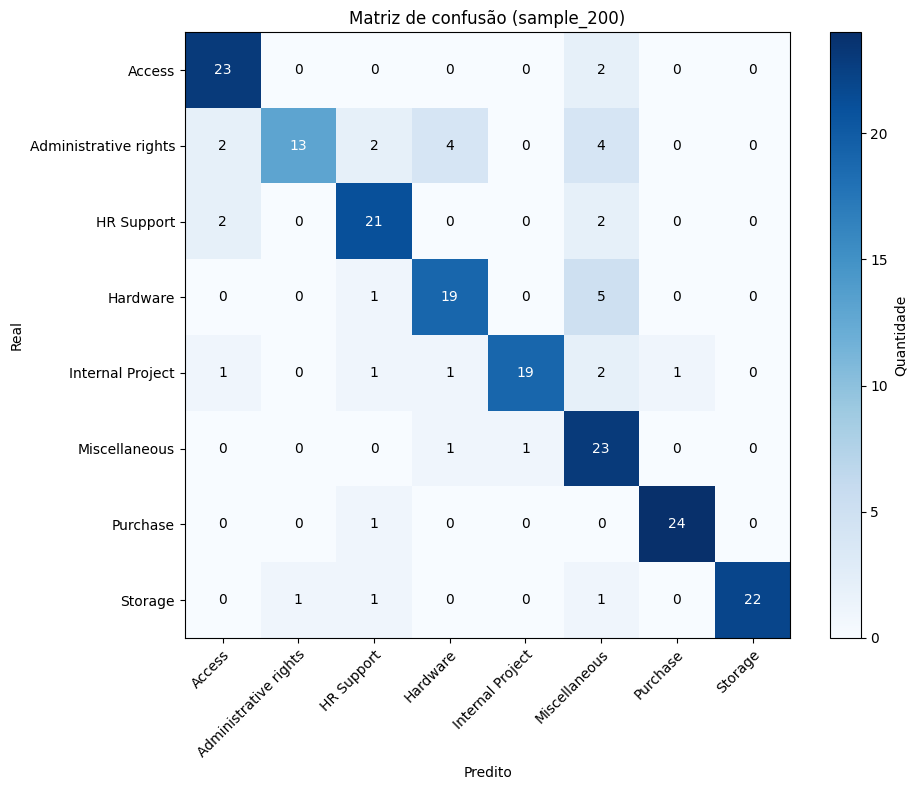

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, predictions, labels=classes)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
fig.colorbar(im, ax=ax, label="Quantidade")
ax.set_title("Matriz de confusão (sample_200)")
plt.tight_layout()
plt.show()

## 5. Exemplo de saída JSON

In [ ]:
import json
ex = run_pipeline(compiled, texts[0], classes)
print(json.dumps(ex, indent=2, ensure_ascii=False))

{
  "classe": "Hardware",
  "justificativa": "Os termos 'monitor', 'vulcan' e 'log' correlacionam com a classe 'Hardware' pois mencionam equipamentos e processos de gerenciamento de logs. Além disso, os vizinhos KNN também mencionam 'monitor' e 'log', o que reforça a correlação com a classe 'Hardware'.",
  "classification_source": "knn",
  "confidence": 1.0,
  "inference_time_sec": 18.991413499999908,
  "classification_tokens": null,
  "justification_tokens": 484
}


## Discussion

**Por que threshold 0 teve métricas maiores?** O pipeline híbrido usa um LLM self-hosted quantizado (ex.: via llama.cpp) com modelo pequeno, poucos parâmetros e few shot prompt, tipicamente rodando em CPU. Esse cenário implica: (1) **capacidade de generalização limitada** — modelos menores têm menos “conhecimento” e pior desempenho em tarefas de classificação multi-classe; (2) **degradação em texto livre** — instruções e justificativas em linguagem natural são mais sensíveis a alucinações e desvios quando o modelo é fraco; (3) **consistência do KNN** — com threshold 0, toda predição vem do KNN (vizinhos + distância L2 no espaço de embeddings), que é determinístico e alinhado à base de treino, elevando accuracy/F1 no benchmark.

**Custo de depender 100% do KNN:** Com threshold 0 o sistema fica totalmente atado à knowledge base. Entradas muito novas, disruptivas ou fora da distribuição dos embeddings tendem a ser classificadas pelo vizinho mais próximo mesmo quando pouco representativas; sem um ramo LLM capaz de generalizar, o modelo híbrido perde valor nesses casos.

**Papel do threshold (ex.: 0,45):** Com um threshold como 0,45, exemplos em que o KNN tem confiança baixa (distância alta ou vizinhos ambíguos) são enviados ao LLM. Isso **reduz** o uso de predições pouco confiáveis do KNN e, em tese, permitiria ao LLM corrigir casos difíceis — desde que o LLM fosse suficientemente bom. No estado atual, como o LLM self-hosted é fraco, esse desvio para o LLM tende a **piorar** as métricas em relação ao 100% KNN.

**Como melhorar o benchmark:** (1) Rodar o LLM em **GPU** (ou usar modelo Groq) para inferência mais rápida e estável. (2) Computar **embeddings** em GPU (e.g. com sentence-transformers ou backend ONNX/CUDA). (3) Calcular **distâncias L2** (e o KNN) em GPU, por exemplo com FAISS-GPU ou cupy, para acelerar a etapa de retrieval e o pipeline como um todo.

**Uso da LLM para justificativa:** De qualquer forma, a LLM segue útil no pipeline: mesmo quando a classe vem do KNN, ela é chamada para **gerar a justificativa** em linguagem natural (campo `justificativa` na saída). Isso traz explicabilidade e auditoria às predições, sem depender do LLM para a decisão de classe.

---